# KNMI Drought Analysis: SPI & SPEI

<em>TODO: WRITE INTRODUCTION</em>

In the [previous Notebook in the series](./02-knmi_data_visualization.ipynb) we crafted a set of insightful visualizations by using the data available to us from the KNMI web script service. 

In this notebook we will go a final step deeper to analyze and even quantify periods of drought and wetness by using so-called <em>Standardized Indexes</em>. 

We will also fill missing values in the dataset using an advanced imputation algorithm called <em>MICE</em> (Multivariate or Multiple Imputation by Chained Equations), which is powered by predictive modelling to fill in missing values in our datasets.

### Disclaimer
I am not officially affiliated with KNMI, and the scripts and insights provided in this Jupyter Notebook are offered on an unofficial basis for educational and exploratory purposes.

## Background

### SPI
SPI stands for the <em>Standardized Precipitation Index</em>.

This metric is widely used to assess meteorological droughts by quantifying precipitation anomalies over a specified time scale. It compares observed precipitation to historical averages, standardizing the values to account for variability in climate and geography. 

Positive SPI values indicate wetter-than-average conditions, while negative values reflect drier-than-average conditions, with thresholds classifying the severity of drought/wetness. 

Its flexibility in evaluating short- to long-term droughts (e.g., agricultural or hydrological) makes it particularly useful for monitoring water resource availability and as an input for e.g. early-warning systems.

By being purely precipitation-based, the SPI provides a straightforward, location-independent tool for assessing drought risk across diverse regions.

### SPEI
SPEI is an abbreviation of <em>Standardized Precipitation Evapotranspiration Index</em>. It was introduced in a scientific paper by Vicente-Serrano et al. (2010) to take the effect of (rising) temperatures into account when reporting about drought. 

Instead of taking the precipiation directly as for the SPI, this index is based on the <em>excess precipitation</em> (precipitation minus reference evaporation).

Currently more meteorological organisations, including KNMI itself, are starting to use the SPEI to report about events of drought and wetness, on top of the already more commonly and broadly used SPI.

For the interested reader, also see [the Wikipedia-article on SPEI](https://en.wikipedia.org/wiki/Standardised_Precipitation_Evapotranspiration_Index).

### SP(E)I Timescales

SP(E)I indexes are commonly calculated on different timescales, with each one emphasizing the impact on different parts of the water system:
- <strong>SP(E)I-1</strong> reflects precipitation anomalies over the past month. It is a short-term indicator sensitive to immediate changes in rainfall, often associated with surface soil moisture conditions and impacts on agriculture.
- <strong>SP(E)I-3</strong> represents anomalies over a 3-month period, capturing seasonal precipitation trends. It’s commonly used to assess short-term agricultural drought and early hydrological impacts.
- <strong>SP(E)I-6</strong> bridges short- and medium-term drought effects. It provides insights into soil moisture, streamflow, and reservoir levels.
- <strong>SP(E)I-9</strong> is often tied to seasonal and medium-term water resource availability, such as impacts on larger reservoirs and river systems.
- <strong>SP(E)I-12</strong> reflects long-term hydrological conditions and water storage. Useful for understanding drought impacts on groundwater and large-scale water resources.
- <strong>SP(E)I-24</strong> captures anomalies over a 2-year period, focusing on prolonged droughts and long-term groundwater and aquifer recharge impacts.

### Why would a Data Scientist be interested in these domain-specific indexes?

TODO: IMPROVE
- Note that weather, and mainly drought/wetness, are important drivers for many phenomena, even outside the direct realm of meteorology and climate. E.g.: predicting or explaining year-by-year agricultural output, to how much ice cream will be consumed over a year,  
- Note that usually drought is experienced, but rarely "quantified", so usually hard to model in DS / ML workflows.

- Standardized Indexes are location- and geography-invariant, which is great

- Machine Learning models generally work very well with normalized datasets. Since the SP(E)I is a Z-score by definition ($ Z = \frac{(X - \mu)}{\sigma} $: the number of standard deviation ($\sigma$) multiples from the mean, $\mu$), they would be a great input parameter to use for feature engineering in any ML use case where weather might play a role.

In [2]:
# This is a good source, which actually tests the fit of empirical data in relation to different distributions!

# Default used in literature is Gamma, but here also Weibull, Exponential and log-normal were tested. 

# https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml

In [3]:
# Also give credits to: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values 
# for a great Python-based MICE example that I could develop further on

## Preparation steps
As usual, we will start by importing the required external and internal modules, scripts and libraries.

### Import external libraries
Note: these are only the external libraries used directly within this Notebook. The Python helper scripts, imported in the subsequent step, may require the installation of additional libraries.

In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [22]:
import matplotlib.pyplot as plt

### Internal imports
In the code below the custom Python helper scripts powering the workflow in this Jupyter Notebook are imported.

In [2]:
import knmi_meteo_ingest
import knmi_meteo_transform
import knmi_meteo_visualize

import knmi_spi_utils
import mice_imputation_utils

# TODO: EXPLAIN SECTIONS / EXAMPLES

### Section 1: SPI analysis for a station with missing data
### Section 2: SPEI analysis for a station with missing data
### Section 3: SPEI long-term analysis for The Bilt

## Section 1: SPI analysis for a station with missing data

In this section we will go through a detailed step-by-step workflow to impute missing precipitation values, calculate SPI indexes over various timeframes, and analyze the results.

Since, as said before, the data quality of the KNMI datasets is very good, there are only a handful of stations with missing periods of data to start with. Because of this, it was actually not that easy to find a good example with missing values for performing imputation on. 

In the section we will work with the meteorological station of Soesterberg (KNMI code: $265$). 

This station is actually located quite closely to KNMI's headquarters in De Bilt. However, having been a military airfield until 2008 ([also see Wikipedia](https://en.wikipedia.org/wiki/Soesterberg_Air_Base)), an on-site meteorological observation station was also present.

### Get full precipitation history of KNMI station
In the cells below we load the full precipitation history for our KNMI station of choice.

Again, feel free to change the station to another one if desired.

In [3]:
# Define code of station of interest
STN_CODE = 265

In [5]:
# Get station details for chosen code (sanity check)
stations_raw = knmi_meteo_ingest.knmi_load_meteo_stations()

# Show details of chosen station (should be non-empty)
stn = (stations_raw[stations_raw["STN"] == STN_CODE]
       .to_dict(orient="list"))

# Assert error with message of valid options for invalid stn. code
valid_stns_str = ", ".join(str(x) for x in stations_raw["STN"])
err_msg = ("Invalid station code (integer) - valid options: "
           f"{valid_stns_str}.")

assert len(stn["NAME"]) > 0, err_msg

# Show details of chosen station
pd.DataFrame(stn)

,STN,LON(east),LAT(north),ALT(m),NAME
0,265,5.274,52.13,13.9,Soesterberg


The cell below might take some time to run (15 - 30 seconds for ~100 years of data), since we are making year-by-year calls to the KNMI web script service.

In [6]:
# Get daily precipiation data from KNMI web script service
df_rainlist_y = []

year_start = 1901 # first year of data @ De Bilt
year_end = 2024

for year in range(year_start, year_end+1):
    df_rain_y = (knmi_meteo_ingest
                 .knmi_meteo_to_df(meteo_stns_list=[STN_CODE],
                                   meteo_params_list=["RH"],
                                   start_date=datetime.date(year, 1, 1),
                                   end_date=datetime.date(year, 12, 31),
                                   mode="day"))
    
    df_rainlist_y.append(df_rain_y)

In [7]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly dfs
df_rain_raw = pd.concat([df for df in df_rainlist_y if not df.empty],
                        ignore_index=True)

In [8]:
# Show the result
df_rain_raw

,STN,YYYYMMDD,RH
0,265,19510901,NaN
1,265,19510902,NaN
2,265,19510903,NaN
3,265,19510904,NaN
4,265,19510905,NaN
...,...,...,...
20576,265,20081114,11.0
20577,265,20081115,21.0
20578,265,20081116,-1.0
20579,265,20081117,NaN


### Clean (transform) dataset
We can improve the readability of the dataset by applying some preset transformations on the "raw" dataset. 

As part of this transformation, all parameters are converted to whole units of measurements (in this case, $mm$) for better interpretability. Furthermore the column names are converted to a more readable format.

In [16]:
# Apply transformations to clean the raw dataset
df_rain = knmi_meteo_transform.transform_param_values(df_rain_raw)

#### Additional correction 1: cut off leading and trailing empty values
As an additional step, we filter out the leading and trailing NaNs from the precipitation series. 

The reason for this extra step is that the KNMI web service returns empty values, but with valid date indexes, for every period that was not part of the original measurement history.

Let's correct for this for our use case in the cell(s) below:

In [17]:
# Cut off leading and trailing NaNs from history dataset;
# in this way we get our actual historical start and end dates
min_idx = df_rain[["rain_sum"]].apply(pd.Series.first_valid_index).max()
max_idx = df_rain[["rain_sum"]].apply(pd.Series.last_valid_index).min()
df_rain = df_rain.loc[min_idx: max_idx, :]

In [18]:
# Show the result
df_rain

,station_code,date,rain_sum
8309,265,1974-06-01,0.300
8310,265,1974-06-02,0.300
8311,265,1974-06-03,7.400
8312,265,1974-06-04,0.000
8313,265,1974-06-05,0.000
...,...,...,...
20574,265,2008-11-12,0.200
20575,265,2008-11-13,0.000
20576,265,2008-11-14,1.100
20577,265,2008-11-15,2.100


#### Additional correction 2: ensure complete month indexes
So far we have successfully cut off leading and trailing empty values (NaNs).

However, for our monthly SPI aggregations (which we will calculate later on), it is easiest to work with completely-full months from start to end.

In the cells below, the first and last month of the dataset are ensured to be filled with NaNs so that any month in the dataset has an index for the entire period within that month.

Let's go ahead and do this in the cell(s) below:

In [19]:
# Now, re-index DataFrame so that it:
# 1. Always starts at first day of the first month found
first_date = df_rain["date"].iloc[0]
last_date = df_rain["date"].iloc[-1]
target_first_date = datetime.date(year=first_date.year, 
                                  month=first_date.month, 
                                  day=1)

# 2. Always ends on last day of last month found
target_last_date = (datetime.date(year=(last_date.year + (last_date.month // 12)),
                                  month=(last_date.month % 12) + 1,
                                  day=1) 
                                  - datetime.timedelta(days=1))

# 3. Always has NaNs for missing indexes in the range
full_month_index = pd.date_range(target_first_date, target_last_date, freq="D")

# Set range of collected non-NaN dates as initial index
df_rain.index = pd.to_datetime(df_rain["date"])

# Reindex to full months
df_rain = df_rain.reindex(full_month_index)

In [20]:
# Show the result
df_rain

,station_code,date,rain_sum
1974-06-01,265.0,1974-06-01,0.3
1974-06-02,265.0,1974-06-02,0.3
1974-06-03,265.0,1974-06-03,7.4
1974-06-04,265.0,1974-06-04,0.0
1974-06-05,265.0,1974-06-05,0.0
...,...,...,...
2008-11-26,NaN,NaN,NaN
2008-11-27,NaN,NaN,NaN
2008-11-28,NaN,NaN,NaN
2008-11-29,NaN,NaN,NaN


Great! Now let's rework the overview to only include the columns that we are interested in:

In [21]:
# Remove station code and "incomplete" date column
drop_cols = ["date", "station_code"]
df_rain = df_rain.loc[:,~df_rain.columns.isin(drop_cols)]

# Rename full-month index to "date"
df_rain = df_rain.rename_axis(index="date")
df_rain

,rain_sum
date,
1974-06-01,0.3
1974-06-02,0.3
1974-06-03,7.4
1974-06-04,0.0
1974-06-05,0.0
...,...
2008-11-26,NaN
2008-11-27,NaN
2008-11-28,NaN


### Quick precipitation plot
Let's create a quick visualization of the precipitation timeseries for this station:

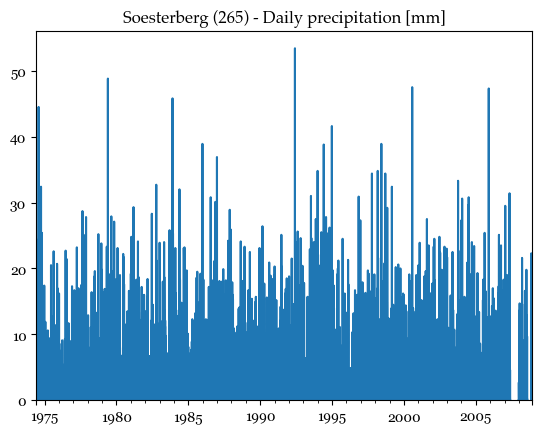

In [42]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Daily precipitation [mm]")

# Ensure only the precipitation column is plotted
ax = df_rain[["rain_sum"]].plot()

# Customize title and layout
ax.set_title(plot_title, **textfont)

# Customize x-label and legend (make invisible)
ax.set_xlabel(None)
ax.get_legend().remove()

# Customize font of the tick markers
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)

# Enforce correct y-axis limits for precipitation
ax.set_ylim(0, 1.05 * df_rain.max().max())

plt.show()

#### Observations
The precipitation dataset for our KNMI station of choice (Soesterberg) covers a period between 1974 and 2008, where only a few timespans post-2005 seem to be absent.

Let's follow up by pinpointing exactly which months contain missing values.

### Obtain monthly summary of missing values

#### Ensure that dates are in a column
For the (month-based) grouping to function correctly, we need to ensure that the dates are part of one of the columns instead of an index:

In [44]:
# Convert full date into column for Grouper
if df_rain.index.name == "date":
    df_rain = df_rain.reset_index()

df_rain

,date,rain_sum
0,1974-06-01,0.3
1,1974-06-02,0.3
2,1974-06-03,7.4
3,1974-06-04,0.0
4,1974-06-05,0.0
...,...,...
12597,2008-11-26,NaN
12598,2008-11-27,NaN
12599,2008-11-28,NaN
12600,2008-11-29,NaN


#### Apply grouping with a custom aggregation
In order to calculate totals based on any kind of group, we make use of the convenience <code>pd.Grouper</code> object from Pandas.

Standard aggregation functions to run on grouped data are e.g. the <em>mean</em>, <em>count</em> or <em>sum</em>. 

However, in the cell below, we will define and apply our own custom lambda function. In this way we can directly calculate the <em>percentage of missing values</em> (NaNs) in each group, with each group representing a month in the dataset.

In [45]:
# Create custom aggregator for counting NaN percentage per group
agg_func = lambda x: 100.0 * np.mean(np.isnan(x))
agg_obj = pd.NamedAgg(column="rain_sum",
                      aggfunc=agg_func)

# Define grouper to group dates by month; keep month starts as label
grouper_obj = pd.Grouper(key="date", freq="MS")

# Perform grouping to the df to get monthly NaN percentages
df_rain_grouped = (df_rain.groupby(grouper_obj)
                   .agg(month_nan_perc=agg_obj))

In [48]:
# Show the result
df_rain_grouped

,month_nan_perc,month,year
date,,,
1974-06-01,0.000000,6,1974
1974-07-01,0.000000,7,1974
1974-08-01,0.000000,8,1974
1974-09-01,0.000000,9,1974
1974-10-01,0.000000,10,1974
...,...,...,...
2008-07-01,9.677419,7,2008
2008-08-01,100.000000,8,2008
2008-09-01,100.000000,9,2008


#### Convert overview to pivoted table
Let's continue and convert our "long"-format DataFrame to a "wide"-format to get a clearer visual result of the outcome.

In [46]:
# Now, pivot on 'month' as cols, 'year' as index
df_rain_grouped["month"] = df_rain_grouped.index.month
df_rain_grouped["year"] = df_rain_grouped.index.year

df_rain_monthpivot = (df_rain_grouped
                      .pivot_table(index="year", columns="month",
                                   values="month_nan_perc"))

In [51]:
# Show the (rounded) result
df_rain_monthpivot.round(1)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1974,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Find months with missing values from dataset
df_rain_grouped[df_rain_grouped["month_nan_perc"] > 0]

,result,month,year
date,,,
2005-07-01,3.225806,7,2005
2007-05-01,29.032258,5,2007
2007-06-01,100.000000,6,2007
2007-07-01,100.000000,7,2007
2007-08-01,100.000000,8,2007
2007-09-01,100.000000,9,2007
2007-10-01,100.000000,10,2007
2007-11-01,100.000000,11,2007
2007-12-01,83.870968,12,2007


Great! At this point we have clearly identified the timelines of our missing data points.

### Imputing missing data

There are many ways to handle missing data. What frequently happens in data analysis and Machine Learning workflows, is that missing data is dropped or ignored outright. Although this speeds up experimentation and certainly simplifies workflows, it rarely yields the best results.

Another popular approach is filling missing values with summary statistics (<em>single imputation methods</em>), e.g.: the <em>mean</em>, <em>median</em> or <em>most-frequent</em> value. This is usually more accurate than dropping data, but still oversimplifies or discards useful patterns that might exist in the empty data rows.


#### MICE
In this analysis we are going a step beyond and apply a more advanced approach called <strong>MICE</strong>: <em>Multiplicative</em> or <em>Multiple Imputation by Chained Equations</em>. 

This approach works on an iterative basis. For each variable with missing data, a predictive model is built using the other variables, and missing values are imputed based on this model. This process is repeated for all variables in a "chained" manner until convergence is reached. 

By creating multiple imputed datasets, MICE accounts for the uncertainty of missing values. This allows for robust statistical analyses and insights without introducing bias as from <em>single imputation methods</em>.

Unfortunately, unlike R, for which a [directly available "MICE" package](https://amices.org/mice/) exists, Python does not (yet) have a similar built-in library for applying a MICE algorithm directly.

Thankfully, [the brief but great tutorial from NumpyNinja in this link](https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values) provides a clear explanation on using <code>sklearn</code>'s experimental <code>IterativeImputer</code> object to reach the same objective. 

#### Custom implementation for our analysis
The default MICE algorithm use case aims to fill empty values from <u>all</u> feature columns in a dataset. 

However, in our analysis here we are primarily interested in filling empty values for <u>one</u> specific column: the precipitation data of our KNMI station of interest.

In helper script <code>mice_imputation_utils</code>, a randomly sampled 25 % of the data from our column of interest will be used for evaluating various prediction models, namely:
- Linear Regression
- Ridge
- Lasso
- Bayesian Ridge
- Random Forest Regressor (Machine Learning-based)
- Gradient Boosting Regressor (Machine Learning-based)
- K-Nearest Neighbors Regressor (Machine Learning-based)

The model that provides the most accurate imputation values is then chosen as our best imputer, and subsequently applied to the full dataset to impute the missing values from that column.

In short: not only will we apply a MICE algorithm, but we will also choose the <em>best-working</em> imputer from a wide range of prediction models to fill our missing values!

That being said, let's move forward to see this approach in action.

#### Which features to use?

Since KNMI possesses many stations in which precipitation is measured, we will use the precipitation values from <em>other stations</em> to use as features for our imputation dataset.

The MICE-algorithm order of complexity scales non-linearly with the number of features (and therefore the amount of time needed to run it). 

For this reason we will only select the $5$ best-correlating other stations as features for our imputation dataset.

#### Find full years to run imputation for
For starters, there are many possible ways in which we can choose the periods for our imputation dataset.

In order to strike a balance between accuracy (the more data, the better) and computation time (the less data, the faster), we will fetch and use the other-station data for all <strong>full years</strong> in which any row (day) of missing data was found.

Words of caution:
- Please note that in case you use another measurement station for your analysis, the method outlined below might not work (well) if all years in your dataset have almost 100 % missing data.
- On the other hand, if only a few days of data are missing from your dataset, a simpler imputation method or outright dropping of the data will only minimally impact the final calculations. In those cases, the method followed below will be somewhat over-engineered for your use case.

In [54]:
# Find unique years to run imputation for
years_to_impute = list(set((df_rain_grouped
                   [df_rain_grouped["month_nan_perc"] > 0]
                   ["year"]).tolist()))

years_to_impute.sort()

print(years_to_impute)

[2005, 2007, 2008]


#### Fetch data of other KNMI stations

In the cells below we fetch the daily precipitation values of all other KNMI meteo stations for the full years to impute for:

In [55]:
try_impute = False
df_implist_y = []

if len(years_to_impute) > 0:
    # Get rain data of all stations for years to impute for
    try_impute = True

    for year in years_to_impute:
        df_imp_y = (knmi_meteo_ingest
                    .knmi_meteo_to_df(
                        meteo_stns_list=None,
                        meteo_params_list=["RH"],
                        start_date=datetime.date(year, 1, 1),
                        end_date=datetime.date(year, 12, 31),
                        mode="day")
                    )
    
        df_implist_y.append(df_imp_y)

In [56]:
# Concatenate each non-empty yearly series to full history;
# note: use 'ignore_index' to deduplicate indexes from yearly dfs
if try_impute:
    if len(df_implist_y) > 0:
        df_imp_raw = pd.concat(
            [df for df in df_implist_y if not df.empty],
            ignore_index=True)

#### Clean (transform) imputation dataset

As usual, we clean the "raw" KNMI meteo dataset as in the cell below.

In [57]:
if not try_impute:
    df_imp = pd.DataFrame()

if try_impute:
    # Apply transformations to clean the raw dataset
    df_imp = (knmi_meteo_transform
              .transform_param_values(df_imp_raw))

# Show the result
df_imp

,station_code,date,rain_sum
0,209,2005-01-01,NaN
1,209,2005-01-02,NaN
2,209,2005-01-03,NaN
3,209,2005-01-04,NaN
4,209,2005-01-05,NaN
...,...,...,...
52973,391,2008-12-27,0.0
52974,391,2008-12-28,0.0
52975,391,2008-12-29,0.0
52976,391,2008-12-30,0.0


#### Pivot the imputation dataset

Instead of having a "long"-format DataFrame, let's pivot the overview towards one where the dates are indexes and the KNMI station code are columns.

In [58]:
if not try_impute:
    df_imp_pivot = pd.DataFrame()

if try_impute:
    # Pivot data with 'date' as index, 'stn_code' as cols
    df_imp_pivot = (df_imp.pivot(index="date",
                                 columns="station_code"))

    # Flatten pivot table to single index
    df_imp_pivot.columns = (df_imp_pivot.columns
                            .get_level_values(1))
    
# Show the result
df_imp_pivot

station_code,209,210,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,1.5,NaN,0.600,2.100,NaN,NaN,1.4,4.0,0.7,...,NaN,1.2,2.100,1.4,3.1,1.000,1.9,0.900,1.000,1.100
2005-01-02,NaN,0.1,NaN,0.025,0.000,NaN,NaN,0.0,0.4,0.0,...,NaN,0.0,0.025,0.7,0.0,0.500,0.0,0.200,0.000,0.700
2005-01-03,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,1.6,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.2,0.025,0.025,0.025
2005-01-04,NaN,0.9,NaN,3.300,1.500,NaN,NaN,1.5,0.4,1.1,...,NaN,3.1,1.200,0.4,1.2,0.025,0.3,0.025,0.400,0.100
2005-01-05,NaN,2.4,NaN,4.400,3.300,NaN,NaN,4.4,3.3,3.9,...,NaN,1.2,1.500,1.6,1.8,0.800,1.5,1.000,2.100,0.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-27,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-28,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
2008-12-29,NaN,0.0,NaN,0.000,0.000,NaN,NaN,0.0,0.0,0.0,...,NaN,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000


#### Sort stations based on correlation with our chosen station

Now we calculate the correlation of all other stations with regard to our station of interest, and sort the results by value. 

In [61]:
# Sort all stations on correlation with target station;
# the station itself will have a value of 1 (by definition)
if try_impute:
    corr_scores = (df_imp_pivot
                   .corrwith(df_imp_pivot[STN_CODE])
                   .sort_values(ascending=False))
    print(corr_scores)

station_code
265    1.000000
260    0.933660
356    0.845402
275    0.841238
240    0.792410
210    0.790389
257    0.775355
375    0.775257
269    0.772231
370    0.759260
330    0.753599
348    0.751736
283    0.742983
344    0.741021
249    0.730716
290    0.727423
278    0.709835
377    0.669297
273    0.661622
235    0.641102
267    0.640624
350    0.638358
323    0.614019
279    0.602763
391    0.588620
319    0.580390
286    0.571121
280    0.567938
270    0.551835
251    0.534557
380    0.518981
277    0.515362
310    0.454668
209         NaN
225         NaN
242         NaN
248         NaN
258         NaN
285         NaN
308         NaN
311         NaN
312         NaN
313         NaN
315         NaN
316         NaN
324         NaN
331         NaN
340         NaN
343         NaN
dtype: float64


#### Only keep best-correlating other stations
As mentioned before, the MICE algorithm scales nonlinearly for every extra feature (column) added. 

Because of this, let's choose to only use the $5$ best-correlating other meteo stations as imputation feature columns. 

In [62]:
run_impute = False

if try_impute:
    # Find up to N best-correlating stations for imputation years
    # Note: less stations will be used in case of empty results
    nr_impute_stns = 5

    # Drop NaNs from the correlation scores
    corr_scores = corr_scores[~corr_scores.isna()]

    # Get maximum index (minimum of N and non-NaN corr elements)
    max_corr_idx = min(1 + nr_impute_stns, len(corr_scores))
    impute_stn_codes = corr_scores[1 : max_corr_idx].index.tolist()

    # Print warning message in case of all-NaN correlations
    warn_msg = ("No matching stations found for MICE imputation; use "
               "another method or drop missing data instead of imputing.")
    if len(impute_stn_codes) == 0:
        print(warn_msg)
        run_impute = False
    else:
        run_impute = True

    # If all OK, print external station codes to use for imputation
    print(impute_stn_codes)

[260, 356, 275, 240, 210]


Fantastic! Now that we have identified which stations to use for our imputation dataset, we can filter out the others. 

In that way we will be left with only the most important feature columns.

In [63]:
# Placeholder for pretty printing in all scenarios
df_imp_sel = pd.DataFrame()

if run_impute:
    # Define colums to keep for imputation calculation
    keep_cols = [STN_CODE] + impute_stn_codes

    # Apply column filter
    df_imp_sel = df_imp_pivot.loc[:, df_imp_pivot.columns.isin(keep_cols)]

    # Ensure that our target impute column is always the first
    df_imp_sel = df_imp_sel[[STN_CODE] + impute_stn_codes]

    # Get maximum value from imp. dataset; no imp. value should be larger
    max_imp_val = np.nanmax(df_imp_sel.values)

# Show the result (table with data to use for imputation, if any)
df_imp_sel

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600,1.300,3.1,2.6,2.100,1.5
2005-01-02,0.025,0.025,0.0,0.1,0.000,0.1
2005-01-03,0.000,0.000,0.0,0.0,0.000,0.0
2005-01-04,1.100,1.600,1.2,1.4,1.500,0.9
2005-01-05,3.400,3.200,1.8,2.8,3.300,2.4
...,...,...,...,...,...,...
2008-12-27,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-28,NaN,0.000,0.0,0.0,0.000,0.0
2008-12-29,NaN,0.000,0.0,0.0,0.000,0.0


#### Test and fit best MICE imputation model to dataset

By now our imputation dataset is all set up and ready for the heavy-lifting exercise: testing and fitting the vast range of different predictor models, enabling us to find the best-performing imputer on our precipitation dataset.

In helper script <code>mice_imputation_utils</code>, a function was written to conveniently do all this for us automatically.

The best-performing model is defined based on a mix of $R^2$ and $RMSE$, using the following scoring formula:

$score = \alpha \cdot RMSE - (1 - \alpha) \cdot (1 - R^2)$

The script below uses $\alpha = 0.50$ by default. It can be set dynamically by changing input parameter <code>rmse_r2_alpha</code>.

Depending on the ease of convergion of the found solutions, particularly for the Machine Learning-based predictors, the code below will run for 30 seconds to several minutes. 

Note that the removal of the Machine Learning-based predictors from the list of models to try and fit (in script <code>mice_imputation_utils</code>) would cause the script below to run tremendously faster.

In [64]:
if not run_impute:
    df_imp_filled = pd.DataFrame()

if run_impute:
    (best_imputer, best_res, df_imp_filled) = (
        mice_imputation_utils
        .fit_best_df_imputer_on_targetcol(df_imp_sel, STN_CODE)
    )

df_imp_filled

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 2.4015, R^2: 0.8838, score: 0.7168
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 2.4015, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 1.0}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 10.0}, MSE: 2.3991, R^2: 0.8839, score: 0.7164
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 0.01}, MSE: 2.3984, R^2: 0.8840, score: 0.7163
  Params: {'alpha': 0.1}, MSE: 2.3792, R^2: 0.8849, score: 0.7137
  Params: {'alpha': 1.0}, MSE: 2.4937, R^2: 0.8794, score: 0.7292
  Params: {'alpha': 10.0}, MSE: 7.4999, R^2: 0.6372, score: 1.1879
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 2.1170, R^2: 0.8976, score: 0.6763
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 2.1550, R^2: 0.8957, score: 0.6819
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 2.3326, R^2: 0.8871, score: 0.7072
  Params: {'max_depth': 3,

station_code,265,260,356,275,240,210
date,,,,,,
2005-01-01,1.600000,1.300,3.100,2.600,2.100,1.5
2005-01-02,0.025000,0.025,0.000,0.100,0.000,0.1
2005-01-03,0.000000,0.000,0.000,0.000,0.000,0.0
2005-01-04,1.100000,1.600,1.200,1.400,1.500,0.9
2005-01-05,2.817817,3.200,1.800,2.800,3.300,2.4
...,...,...,...,...,...,...
2008-11-12,1.276591,0.700,1.200,1.500,2.500,5.1
2008-11-13,0.203411,0.100,0.025,0.100,0.025,1.4
2008-11-14,1.263952,0.800,0.900,1.300,0.900,0.4


In [74]:
# Print (hyperparameter) properties of best-fit model
if run_impute:
    print(best_imputer.estimator)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)


Quite impressive! 

For KNMI station Soesterberg, the best-performing model is a Random Forest regressor with a max. depth of 5 tree layers and 50 estimators. 

More complex (deeper, more estimators) models were tested, but apparently this mid-complexity hyperparameter setup strikes the best balance between reflecting the patterns within the data, while simultaneously not overfitting purely on the data seen.

The $R^2$ of the tested imputation values (compared to the real ones within that 25 % withheld subset) is almost 91 %, with a $RMSE$ of 1.36 $mm$. 

Also note from the output of the cells above that the baseline linear regression model would already have yielded quite decent results as well ($RMSE$ of 1.55 $mm$, $R^2 \approx 88.4 \% $), while simultaneously saving us a lot of computing time.

#### Fill missing dataset values using the best-fit imputer
Let's unleash our best-performing imputer on the full to-impute dataset, so that we can definitively say goodbye to any missing values for our example of interest.

In [70]:
if not run_impute:
    df_imputed = pd.DataFrame()
if run_impute:
    # Now fit and run the best imputer on the *full* to-impute dataset
    df_imputed = pd.DataFrame(data=best_imputer.fit_transform(df_imp_sel),
                              columns=df_imp_sel.columns,
                              index=df_imp_sel.index)

    # Only keep imputed values that were missing in dataset
    df_imputed["init_val"] = df_imp_sel[STN_CODE]
    df_imputed = df_imputed[df_imputed["init_val"].isna()]
    df_imputed = df_imputed.loc[:, [STN_CODE]]

    # Convert index type to DateTime
    df_imputed.index = pd.to_datetime(df_imputed.index)

    # Rename columns and reset 'date' col; show the result
    df_imputed = (df_imputed
                  .rename(columns={STN_CODE: "rain_sum_imputed"})
                  .reset_index())

df_imputed

station_code,date,rain_sum_imputed
0,2005-07-31,16.091713
1,2007-05-23,0.008186
2,2007-05-24,0.008186
3,2007-05-25,0.008186
4,2007-05-26,1.582548
...,...,...
358,2008-12-27,0.008186
359,2008-12-28,0.008186
360,2008-12-29,0.008186
361,2008-12-30,0.008186


#### Merge original dataset with imputed dataset
Now it is time to merge the imputed dataset with the original dataset. 

We will keep the dataset columns separate for now. This will enable us to mark imputed data separately later on.

Also note that we lose some of the imputed values during merging (for our example of interest), since the imputed values for Dec 2008 fall outside of the station's measurement history. 

If keeping those days is desired, change the merge rule in the cell below from "left" to "outer".

In [72]:
if run_impute:
    # Merge imputed data with measured data if imputation was run
    df_rain_all = df_rain.merge(df_imputed, how="left", on="date").round(2)
else:
    # If no missing data were found, only add all-NaN imputation column
    df_rain_all = df_rain.copy()
    df_rain_all["rain_sum_imputed"] = np.nan

df_rain_all

,date,rain_sum,rain_sum_imputed
0,1974-06-01,0.3,NaN
1,1974-06-02,0.3,NaN
2,1974-06-03,7.4,NaN
3,1974-06-04,0.0,NaN
4,1974-06-05,0.0,NaN
...,...,...,...
12597,2008-11-26,NaN,0.69
12598,2008-11-27,NaN,0.10
12599,2008-11-28,NaN,0.01
12600,2008-11-29,NaN,0.28


In [152]:
print("Values in original dataset: "
      f"{df_rain_all["rain_sum"].notna().sum()}"
      "\nValues in imputed dataset: "
      f"{df_rain_all["rain_sum_imputed"].notna().sum()}")

Values in original dataset: 12270
Values in imputed dataset: 332


### Quick plot of measured and imputed precipitation
Let's create a new precipitation plot for this station, now with imputed values included as well:

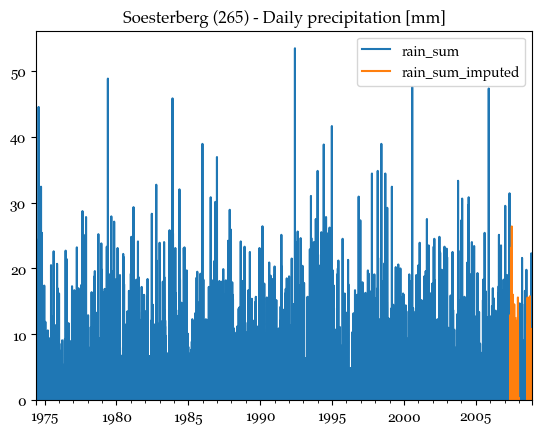

In [ ]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Daily precipitation [mm]")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot()

# Customize title and layout
ax.set_title(plot_title, **textfont)

# Customize x-label (make invisible) and legend text
ax.set_xlabel(None)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)

# Enforce correct y-axis limits for precipitation
y_max = 1.05 * np.nanmax(df_rain_all.set_index("date").values)
ax.set_ylim(0, y_max)

plt.show()

#### Observations
When looking at the imputed precipitation data at a first glance, it seems like they could have been part of the original precipitation dataset.

Mainly the peaks seem to absent in the imputed dataset. The reason for this can be twofold: either no heavy-rain days were present in the period of the imputed dataset, or heavy rain during that timeframe was too localized to be picked up from the measurements of the other stations.

### Comparing distributions of measured and imputed precipitation

Let's dive a bit deeper into the actual data distributions of the measured data and the imputed data.

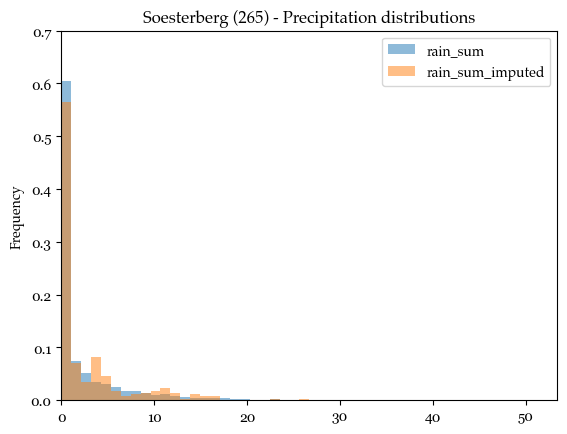

In [ ]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Precipitation distributions")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot(
          kind="hist", bins=50, density=True,
          alpha=0.5
      )

# Customize title and layout
ax.set_title(plot_title, **textfont)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_ylabel(ax.get_ylabel(), **textfont)

# Enforce correct x-axis histogram limits 
x_max = np.nanmax(df_rain_all.set_index("date").values)
ax.set_xlim(0, x_max)

plt.show()

#### Observations
Generally speaking, the distributions of the imputed (orange) and measured (blue) datasets seem to align quite well. 

The imputed data shows a slightly higher tendency to estimate the rainfall being 3 - 4 mm or between 10 - 20 mm compared to the measured data, where there seems to be a slight under-bias for estimating (near)-zero-precipitation days.

However, we must keep in mind that for our example of interest the number of imputed day values are only around 332, where the measured dataset contains 12270 records. 

Because of this, the imputed data will show more short-term seasonal effects than the all-history measured precipitation values.

#### Log-distribution comparison
The higher precipitation values barely show up in the originally-scaled distribution plot, since they occur relatively rarely.

By using a logarithmic scale for the y-axis, we can show the comparison between the data distributions for those values more clearly below.

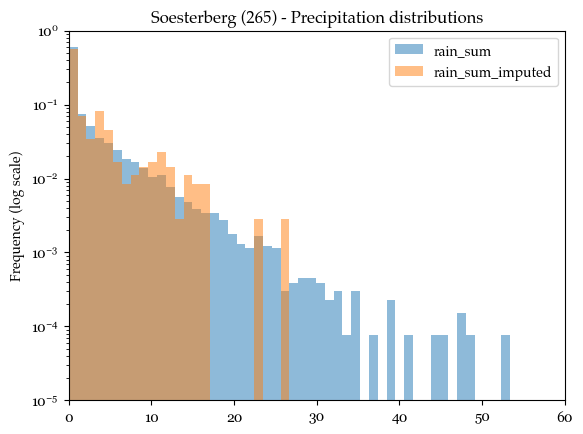

In [ ]:
# Define custom styles for plot text and ticks
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Dynamically generate title for plot
plot_title = (f"{stn["NAME"][0]} ({stn["STN"][0]}) "
              "- Precipitation distributions")

# Ensure only the precipitation columns are plotted
ax = (df_rain_all.set_index("date")
      [["rain_sum", "rain_sum_imputed"]]).plot(
          kind="hist", bins=50, density=True,
          logy=True, alpha=0.5
      )

# Customize title and layout
ax.set_title(plot_title, **textfont)

for text in ax.get_legend().get_texts():
    text.set_fontname(textfont["fontname"])

# Customize font of the tick markers and labels
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_ylabel(f"{ax.get_ylabel()} (log scale)", **textfont)

# Enforce correct x- and y-axis histogram limits 
ax.set_xlim(0)
ax.set_ylim(1e-5, 1e0)

plt.show()

#### Observations
It becomes clear that the imputed values do not exceed the 25 $mm$-mark, where the full measured dataset has several occcurrences that have a much higher peak (up to over 50 $mm$).

However, what must be noted is that any frequency below $1 / 332  \approx 3 \cdot 10^{-2}$ is not possible for the imputed dataset, and therefore cannot be modeled well.

With that in mind, it seems like the high-peak precipitation days occur too rarely to be accurately captured within the limited timeframe of the imputation dataset.

Let's confirm below whether we actually had any high peak-intensity rainfall during the timeframe of imputation to start with.

In [ ]:
# Start and end date filters
start_date = df_rain_all["date"].min().date()
end_date = df_rain_all["date"].max().date()

# Filter for only showing rows for timeframe of imputed data
is_imput_row = (df_imp_pivot.index.isin
                ([d.date() for d in df_imputed["date"]]))

# Filter for start and end date
is_in_date_range = ((df_imp_pivot.index >= start_date)
                    & (df_imp_pivot.index <= end_date))

In [151]:
# Apply all filters to original imputation dataset;
# check upper-bound extreme values
((df_imp_pivot
  [impute_stn_codes]
  [is_imput_row & is_in_date_range]
  ).describe(percentiles=[0.5, 0.99, 0.995, 0.9975, 0.999]))

station_code,260,356,275,240,210
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,2.874398,2.728991,2.502711,2.802861,2.807455
std,5.141176,5.336327,4.531154,5.729920,5.371223
min,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.200000,0.350000,0.350000,0.300000
99%,23.187000,20.466000,22.105000,26.114000,20.876000
99.5%,27.072500,28.687500,26.686500,41.528000,36.952500
99.75%,29.142250,36.429000,27.817250,43.962500,40.003500
99.99%,37.165690,49.457160,27.896690,47.934500,40.480140
max,37.500000,50.000000,27.900000,48.100000,40.500000


#### TODO: Refer to 99.5 (1/200), 99.75 (1/400) and 99.99 (1/1000) values to conclude that a maximum encountered prediction of just below 30 mm seems reasonable (as percentiles for different stations are not likely to occur at the exact same time, and are already in the 30 mm - 40 mm range)

Furthermore: local effects? ("Hole" effect)

### Use complete precipitation dataset to fit to a distribution


In [46]:
# Keep track of fact whether data was imputed or not
df_rain_all["is_imputed"] = (df_rain_all["rain_sum"].isna() 
                             & ~df_rain_all["rain_sum_imputed"].isna())

# Create a fully-filled column with mixed real and imp. values
# Start by filling the column with the originally measured data
df_rain_all["rain_sum_all"] = df_rain_all["rain_sum"].copy()

# Fill the "_all" column with imputed data wherever applicable
filter_idxs = df_rain_all[df_rain_all["rain_sum_all"].isna()].index
df_rain_all.loc[filter_idxs, "rain_sum_all"] = df_rain_all["rain_sum_imputed"].copy()

df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1974-06-01,0.3,NaN,False,0.30
1,1974-06-02,0.3,NaN,False,0.30
2,1974-06-03,7.4,NaN,False,7.40
3,1974-06-04,0.0,NaN,False,0.00
4,1974-06-05,0.0,NaN,False,0.00
...,...,...,...,...,...
12597,2008-11-26,NaN,0.69,True,0.69
12598,2008-11-27,NaN,0.10,True,0.10
12599,2008-11-28,NaN,0.01,True,0.01
12600,2008-11-29,NaN,0.28,True,0.28


In [47]:
# Only keep parameter column and imputation label (yes/no)
keep_cols = ["date", "rain_sum_all", "is_imputed"]
df_rain_sel = df_rain_all[keep_cols]

df_rain_sel

,date,rain_sum_all,is_imputed
0,1974-06-01,0.30,False
1,1974-06-02,0.30,False
2,1974-06-03,7.40,False
3,1974-06-04,0.00,False
4,1974-06-05,0.00,False
...,...,...,...
12597,2008-11-26,0.69,True
12598,2008-11-27,0.10,True
12599,2008-11-28,0.01,True
12600,2008-11-29,0.28,True


In [48]:
# Set aggregation rules; any aggregate that still has any NaN(s) 
# in its value is summed to NaN as a whole (prevent dist-fit errors)
lambda_sum = lambda x: np.nan if x.isnull().any() else x.sum()
agg_dict = {"rain_sum_all": lambda_sum,
            "is_imputed": "mean"}

In [49]:
# Aggregate dataset to months
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_m_gr = (df_rain_sel
                .groupby(grouper_obj)
                .agg(agg_dict))

df_rain_m_gr

,rain_sum_all,is_imputed
date,,
1974-06-01,55.80,0.000000
1974-07-01,84.02,0.000000
1974-08-01,94.68,0.000000
1974-09-01,124.34,0.000000
1974-10-01,142.84,0.000000
...,...,...
2008-07-01,105.79,0.096774
2008-08-01,99.16,1.000000
2008-09-01,63.53,1.000000


In [50]:
# Test: use rolling window for N months
N = 3
df_rain_sums = df_rain_m_gr.rolling(window=N).agg(agg_dict)

df_rain_sums

,rain_sum_all,is_imputed
date,,
1974-06-01,NaN,NaN
1974-07-01,NaN,NaN
1974-08-01,234.50,0.000000
1974-09-01,303.04,0.000000
1974-10-01,361.86,0.000000
...,...,...
2008-07-01,193.71,0.032258
2008-08-01,244.17,0.365591
2008-09-01,268.48,0.698925


In [51]:
# TODO: Make plot of values; use score of 'is_imputed' as color!
# (Can be done using a scatter plot)

In [52]:
# TODO: Change to import from module!
# Time for fitting a distribution! 

# We will need (just as in: https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml):
# 1. Gamma distribution function (note: totals should be nonzero!)
# 2. Exponential distribution function
# 3. Lognormal distribution function
# 4. Weibull distribution function
dist_names = ["gamma", "expon", "lognorm", "weibull_min"]

df_distr = pd.DataFrame()
df_distr["rain_sum"] = df_rain_sums["rain_sum_all"].copy()

# Just to make sure: set any total of 0 mm to 0.1 mm (to avoid zero-issues with gamma)
# Note: in arid regions, this may not suffice for a good fit
filter_idxs = df_distr[df_distr["rain_sum"] == 0.0].index
df_distr[df_distr.loc[filter_idxs, "rain_sum"]] = 0.1

# Get PDFs and CDFs for each best-fit distribution (using Max. Likelihood Est.)
for dist_name in dist_names:
    dist = getattr(scs, dist_name)

    params = dist.fit(df_distr["rain_sum"].dropna(), method="mle", loc=0)
    
    df_distr[dist_name + "_cdf"] = dist.cdf(df_distr["rain_sum"], *params)
    df_distr[dist_name + "_pdf"] = dist.pdf(df_distr["rain_sum"], *params)

In [53]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf
date,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558
...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722


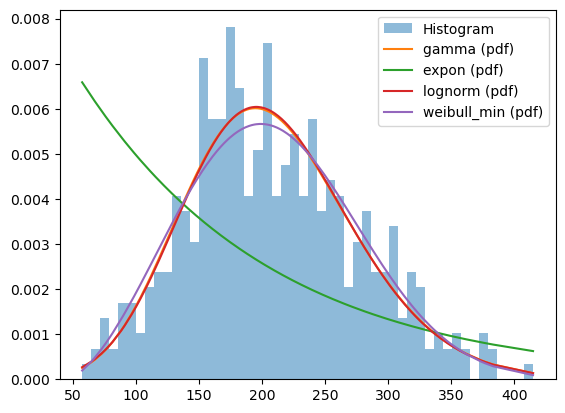

In [54]:
df_d_plot = df_distr.sort_values(by="rain_sum")

plt.hist(df_d_plot["rain_sum"], bins=50, density=True, alpha=0.5, label='Histogram')
x = np.linspace(df_d_plot["rain_sum"].min(), df_distr["rain_sum"].max(), 100)

for distr in dist_names:
    plt.plot(df_d_plot["rain_sum"], df_d_plot[distr + "_pdf"], label=distr + ' (pdf)')

plt.legend()

In [55]:
ecdf_res = scs.ecdf(df_rain_sums["rain_sum_all"].dropna())
df_distr["ecdf"] = ecdf_res.cdf.evaluate(df_rain_sums["rain_sum_all"])
df_distr.loc[df_distr["rain_sum"].isna(), "ecdf"] = np.nan

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398


<Axes: xlabel='rain_sum'>

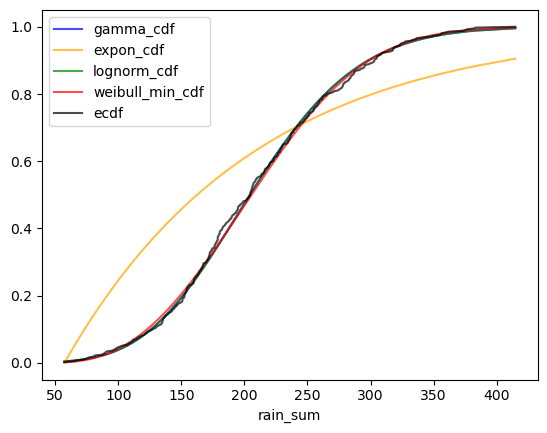

In [56]:
colors = ["blue", "orange", "green", "red", "black"]
df_distr[["rain_sum"] + [d + "_cdf" for d in dist_names] + ["ecdf"]].sort_values(
    by="rain_sum").plot(x="rain_sum", alpha=0.7, color=colors)

In [57]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398


In [58]:
# Calculate the squared differences (L2-norm) between the ECDF and each distribution's CDF
# In this way we can intuitively choose the best-matching one
distances = {}
for dist_name in dist_names:
    # Squared differences (L2-norm)
    squared_diff = (df_distr["ecdf"] - df_distr[dist_name + "_cdf"]) ** 2
    # Sum of squared differences (L2-norm distance)
    distances[dist_name] = squared_diff.sum()

best_fit = min(distances, key=distances.get)

print(distances)
print(best_fit)

{'gamma': 0.05299303883824423, 'expon': 10.802755918847097, 'lognorm': 0.05974459648595951, 'weibull_min': 0.07005827259025206}
gamma


In [59]:
# Apply inverse normal distribution to best-fit CDF
norm_ppf = scs.norm.ppf(df_distr[best_fit + "_cdf"])
norm_ppf[np.isinf(norm_ppf)] = np.nan

df_distr["spi_3"] = norm_ppf.copy()

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf,spi_3
date,,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767,0.437050
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485,1.340915
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437,2.040694
...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456,-0.159351
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592,0.571412
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398,0.898733


<Axes: xlabel='date'>

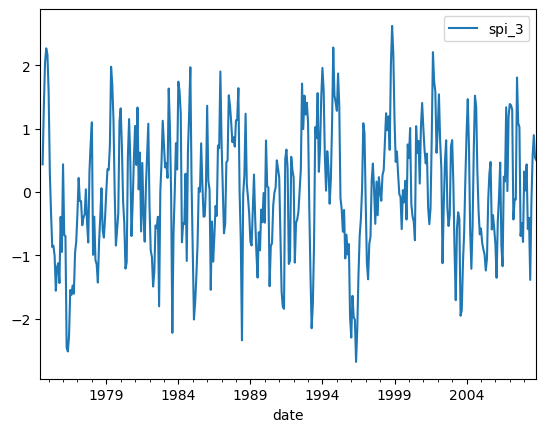

In [60]:
df_distr.reset_index().plot(x="date", y="spi_3")

In [61]:
# Collect all SPI series for one location
df_rain_data = (knmi_spi_utils
                .measured_imputed_to_one_series(df_rain_all, "rain_sum"))
df_m_spi = knmi_spi_utils.calculate_nmonth_spi(df_rain_data, "rain_sum")
 
df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


<Axes: xlabel='date'>

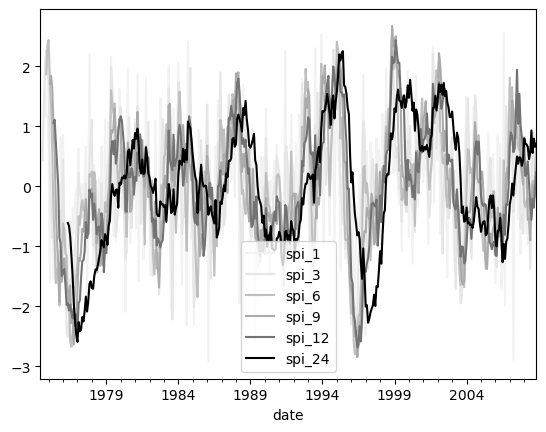

In [62]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spi.loc[:, df_m_spi.columns.str.contains("spi")].plot(color=colors)

Quote from WMO Report:
> A drought event occurs any time the SPI is continuously negative and reaches an intensity of -1.0 or less. The event ends when the SPI becomes positive. Each drought event, therefore, has a duration defined by its beginning and end, and an intensity for each month that the event continues. The positive sum of the SPI for all the months within a drought event can be termed the drought’s “magnitude”.


In [63]:
df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


In [64]:
spi_timeframe_m = 12
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spi, f"spi_{spi_timeframe_m}", "drought"))
events_df.sort_values(f"drought_spi_{spi_timeframe_m}_magnitude", ascending=False)

,drought_spi_12_first_start_idx,drought_spi_12_last_start_idx,drought_spi_12_magnitude,drought_spi_12_duration
0,1975-12-01,1977-07-01,36.06,20
7,1996-01-01,1997-04-01,30.24,16
8,2003-08-01,2003-12-01,5.72,5
10,2006-01-01,2006-02-01,2.31,2
4,1985-10-01,1985-11-01,2.17,2
6,1989-11-01,1989-12-01,2.10,2
1,1978-11-01,1978-11-01,1.43,1
11,2006-07-01,2006-07-01,1.19,1
5,1989-09-01,1989-09-01,1.14,1
2,1979-01-01,1979-01-01,1.12,1


# Section 2: SPEI analysis for a station with missing data

In [65]:
# SPEI calculations; one source: https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-evapotranspiration-index-spei
# Actually calculation is the same, as long as you can calculate P-Eref, and use minimum-value offset for distribution fitting!

In [66]:
# Run a workflow in which RH and EV24 are imputed separately,
# and then combined, fit to distr., which should give SPEI
df_evap = knmi_spi_utils.get_measured_stn_param_values(stn_code=STN_CODE,
                                                       param_col="evap_ref")

In [67]:
(try_impute, years_to_impute) = knmi_spi_utils.check_years_to_impute(df_evap, param_col="evap_ref")

years_to_impute

[1993, 2005, 2007, 2008]

In [68]:
if try_impute:
    (run_impute, impute_stn_codes, df_imp) = (
        knmi_spi_utils.find_imputation_stations(
            stn_code = STN_CODE, 
            years_to_impute = years_to_impute,
            param_col = "evap_ref")
    )

In [69]:
if run_impute:
    df_imp = knmi_spi_utils.filter_datacols_to_impute(df_imp, STN_CODE, impute_stn_codes)
    df_imp

In [70]:
if run_impute:
    df_imputed = knmi_spi_utils.impute_vals_from_targetcol(df_imp, STN_CODE, "evap_ref")
    df_imputed

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 0.0169, R^2: 0.9898, score: 0.0598
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 1.0}, MSE: 0.0163, R^2: 0.9901, score: 0.0590
  Params: {'alpha': 10.0}, MSE: 0.0152, R^2: 0.9908, score: 0.0570
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 0.01}, MSE: 0.0167, R^2: 0.9899, score: 0.0595
  Params: {'alpha': 0.1}, MSE: 0.0196, R^2: 0.9881, score: 0.0641
  Params: {'alpha': 1.0}, MSE: 0.4843, R^2: 0.7066, score: 0.2013
  Params: {'alpha': 10.0}, MSE: 1.6633, R^2: -0.0075, score: 0.1411
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 0.0471, R^2: 0.9715, score: 0.0942
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 0.0430, R^2: 0.9740, score: 0.0906
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 0.0443, R^2: 0.9732, score: 0.0918
  Params: {'max_depth': 3

In [71]:
if not run_impute:
    df_imputed = None

df_evap_all = knmi_spi_utils.merge_measured_and_imputed_data(df_evap, 
                                                             df_imputed, 
                                                             "evap_ref")
df_evap_all

,date,evap_ref,evap_ref_imputed
0,1993-10-01,NaN,0.64
1,1993-10-02,NaN,1.17
2,1993-10-03,NaN,0.22
3,1993-10-04,NaN,0.95
4,1993-10-05,NaN,1.02
...,...,...,...
5535,2008-11-26,NaN,0.19
5536,2008-11-27,NaN,0.08
5537,2008-11-28,NaN,0.11
5538,2008-11-29,NaN,0.27


In [72]:
df_rain_data = knmi_spi_utils.measured_imputed_to_one_series(df_rain_all, "rain_sum")
df_evap_data = knmi_spi_utils.measured_imputed_to_one_series(df_evap_all, "evap_ref")
df_evap_data

,date,evap_ref,is_imputed
0,1993-10-01,0.64,True
1,1993-10-02,1.17,True
2,1993-10-03,0.22,True
3,1993-10-04,0.95,True
4,1993-10-05,1.02,True
...,...,...,...
5535,2008-11-26,0.19,True
5536,2008-11-27,0.08,True
5537,2008-11-28,0.11,True
5538,2008-11-29,0.27,True


In [73]:
df_pcp_data = df_rain_data.merge(df_evap_data, on="date", how="left")

imp_cols = ["is_imputed_x", "is_imputed_y"]
df_pcp_data["is_imputed"] = (df_pcp_data[imp_cols].astype(float)
                             .sum(axis=1, skipna=False) / len(imp_cols))

df_pcp_data["rain_min_evap"] = (df_pcp_data["rain_sum"] 
                                - df_pcp_data["evap_ref"])

keep_cols = ["date", "rain_min_evap", "is_imputed"]
df_pcp_data = df_pcp_data[[col for col in keep_cols]]

df_pcp_data

,date,rain_min_evap,is_imputed
0,1974-06-01,NaN,NaN
1,1974-06-02,NaN,NaN
2,1974-06-03,NaN,NaN
3,1974-06-04,NaN,NaN
4,1974-06-05,NaN,NaN
...,...,...,...
12597,2008-11-26,0.50,1.0
12598,2008-11-27,0.02,1.0
12599,2008-11-28,-0.10,1.0
12600,2008-11-29,0.01,1.0


In [74]:
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_data, "rain_min_evap"))

In [75]:
df_m_spei.dropna(how="all")

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1993-10-01,50.78,0.112903,0.517275,NaN,NaN,NaN,NaN,NaN
1993-11-01,50.20,0.000000,0.404301,NaN,NaN,NaN,NaN,NaN
1993-12-01,176.92,0.000000,2.808460,1.648543,NaN,NaN,NaN,NaN
1994-01-01,106.22,0.000000,1.496795,2.096305,NaN,NaN,NaN,NaN
1994-02-01,16.02,0.000000,-0.401247,1.724402,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,16.26,0.096774,-0.084860,-1.372205,-1.030008,-0.296724,-0.628147,0.654566
2008-08-01,27.23,1.000000,0.106849,-0.683525,-0.898317,-0.380681,-0.278435,0.291901
2008-09-01,14.85,1.000000,-0.213211,-0.079004,-1.276102,-0.676360,-0.427452,0.547217


<Axes: xlabel='date'>

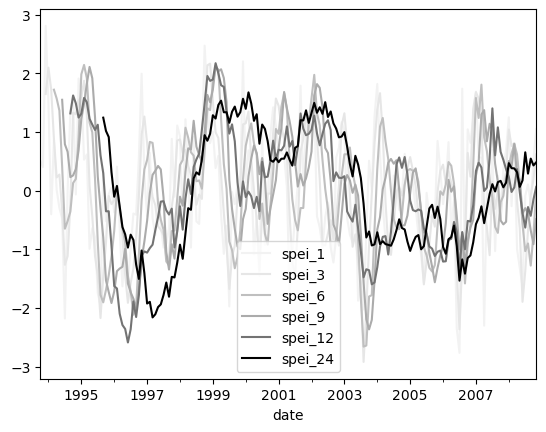

In [76]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")].dropna(how="all").plot(color=colors)

In [77]:
spei_timeframe_m = 6
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, f"spei_{spei_timeframe_m}", "severe_drought"))
events_df.sort_values(f"severe_drought_spei_{spei_timeframe_m}_magnitude", ascending=False)

,severe_drought_spei_6_first_start_idx,severe_drought_spei_6_last_start_idx,severe_drought_spei_6_magnitude,severe_drought_spei_6_duration
2,2003-07-01,2003-11-01,10.71,5
1,1996-07-01,1996-09-01,5.81,3
0,1995-08-01,1995-10-01,5.37,3
3,2006-09-01,2006-09-01,1.58,1


## Section 3: SPEI long-term analysis for De Bilt

In [78]:
# TODO: Run SPEI workflow for The Bilt!
# Goal: find out if droughts and/or extreme wetness are becoming more intense recently

In [82]:
BILT_STN_CODE = 260

In [83]:
df_rain = knmi_spi_utils.get_measured_stn_param_values(stn_code=BILT_STN_CODE,
                                                       param_col="rain_sum")
df_evap = knmi_spi_utils.get_measured_stn_param_values(stn_code=BILT_STN_CODE,
                                                       param_col="evap_ref")

In [84]:
# Run imputation workflow
df_rain_sel = knmi_spi_utils.imputation_workflow(df_rain, "rain_sum", BILT_STN_CODE,
                                                 print_progress = False)
df_evap_sel = knmi_spi_utils.imputation_workflow(df_evap, "evap_ref", BILT_STN_CODE,
                                                 print_progress = True)

No matching stations found for MICE imputation; use another method or drop missing data instead of imputing.


In [85]:
df_evap_sel

,date,evap_ref,is_imputed
0,1957-07-01,3.6,False
1,1957-07-02,4.2,False
2,1957-07-03,3.3,False
3,1957-07-04,3.8,False
4,1957-07-05,3.7,False
...,...,...,...
24651,2024-12-27,0.2,False
24652,2024-12-28,0.1,False
24653,2024-12-29,0.1,False
24654,2024-12-30,0.1,False


In [86]:
df_pcp_sel = knmi_spi_utils.calc_rain_min_evap_df(df_rain_sel, df_evap_sel)

In [87]:
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_sel, "rain_min_evap"))

In [88]:
df_m_spei

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-01,-56.275,0.0,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319
2024-09-01,97.150,0.0,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363
2024-10-01,12.650,0.0,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069


<Axes: xlabel='date'>

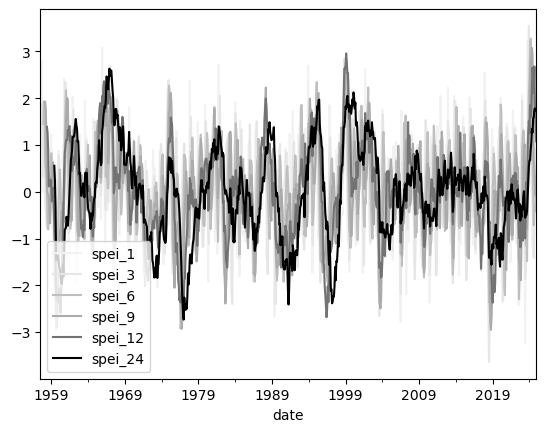

In [89]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")].dropna(how="all").plot(color=colors)

In [90]:
spei_timeframe_m = 6
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, f"spei_{spei_timeframe_m}", "wetness"))
events_df.sort_values(f"wetness_spei_{spei_timeframe_m}_magnitude", ascending=False)

,wetness_spei_6_first_start_idx,wetness_spei_6_last_start_idx,wetness_spei_6_magnitude,wetness_spei_6_duration
43,2023-12-01,2024-05-01,14.69,6
24,1998-10-01,1999-04-01,14.29,7
9,1974-11-01,1975-04-01,10.41,6
5,1965-12-01,1966-05-01,9.67,6
21,1993-12-01,1994-05-01,8.71,6
1,1960-12-01,1961-04-01,8.65,5
22,1995-01-01,1995-05-01,8.64,5
6,1966-11-01,1967-04-01,8.48,6
27,2001-12-01,2002-04-01,7.53,5
38,2017-12-01,2018-04-01,6.86,5


In [91]:
df_m_spei_pivot = df_m_spei.copy()

keep_cols = df_m_spei_pivot.columns.str.contains("spei")
df_m_spei_pivot = df_m_spei_pivot.loc[:, keep_cols].dropna(how="all")

df_m_spei_pivot["month"] = df_m_spei_pivot.index.month
df_m_spei_pivot["year"] = df_m_spei_pivot.index.year

In [92]:
df_m_spei_pivot

,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24,month,year
date,,,,,,,,
1957-07-01,-0.000430,NaN,NaN,NaN,NaN,NaN,7,1957
1957-08-01,1.146221,NaN,NaN,NaN,NaN,NaN,8,1957
1957-09-01,2.792563,1.783387,NaN,NaN,NaN,NaN,9,1957
1957-10-01,0.182129,1.876742,NaN,NaN,NaN,NaN,10,1957
1957-11-01,-0.019732,1.298980,NaN,NaN,NaN,NaN,11,1957
...,...,...,...,...,...,...,...,...
2024-08-01,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319,8,2024
2024-09-01,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363,9,2024
2024-10-01,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069,10,2024


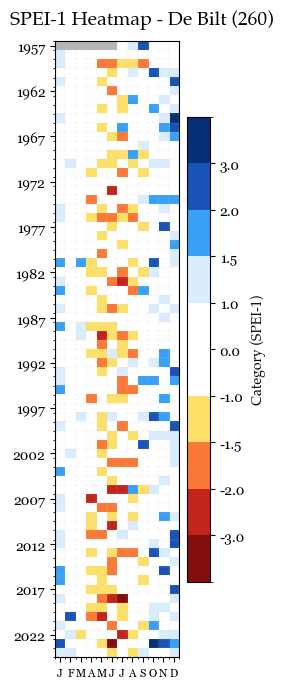

In [96]:
%matplotlib inline

ax = (knmi_meteo_visualize
      .standardized_index_heatmap(df_m_spei_pivot, "spei_1", 
                                  f"De Bilt ({BILT_STN_CODE})"))

# Show the plot
plt.show()

In [94]:
# TODO: Mention existence of SPI/SPEI package for Python: https://github.com/e-baumer/standard_precip

In [95]:
# TODO: Mention where SPI / SPEI results could be used; e.g.: drought monitoring / warning system; Machine Learning 
# (standardized, so great for feature engineering!)